#  **Tittle: Automate sentiment analysis of textual comments and feedback**

###  **Objective:**

*  The main objective of this project is to develop a sentiment analysis model for social media data to classify posts into positive, negative, or neutral sentiments.






###  **Dataset source & brief:**


 *   The dataset, retrieved from Kaggle, comprises 162,980 rows and 2 columns. The primary content is stored in the "clean_text" column, consisting of textual data. The "category" column holds numerical values, specifically 1.0 for positive, 0.0 for neutral, and -1.0 for negative sentiments. This dataset is structured to facilitate sentiment analysis, with each entry classified into one of these three categories based on the associated text.



#  **Importing Necessary Library**

---

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import  BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# **Data Collection**

---

In [ ]:
df=pd.read_csv("/content/Twitter_Data.csv")

In [ ]:
df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [ ]:
#Checking the shape of the data
df.shape

(162980, 2)

In [ ]:
df.columns

Index(['clean_text', 'category'], dtype='object')

In [ ]:
#Checking the dtypes of the variables in the data
df.dtypes

clean_text     object
category      float64
dtype: object

In [ ]:
#Information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [ ]:
df['category'].unique()

array([-1.,  0.,  1., nan])



*   **Negative Sentiment** (-1)

*   **Neutral Sentiment** (0)

*   **Positive Sentiment**(1)







In [ ]:
print(df['clean_text'].iloc[0],"\n")
print(df['clean_text'].iloc[1],"\n")
print(df['clean_text'].iloc[2],"\n")
print(df['clean_text'].iloc[3],"\n")
print(df['clean_text'].iloc[1119],"\n")

when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples 

talk all the nonsense and continue all the drama will vote for modi  

what did just say vote for modi  welcome bjp told you rahul the main campaigner for modi think modi should just relax 

asking his supporters prefix chowkidar their names modi did great service now there confusion what read what not now crustal clear what will crass filthy nonsensical see how most abuses are coming from chowkidars 

mam fault lies with people only elect such dim wits they are the one who bring bad name party give vote for modi but his name sometimes elect filth and hurts 



## **Distribution of Categories in the Dataset**

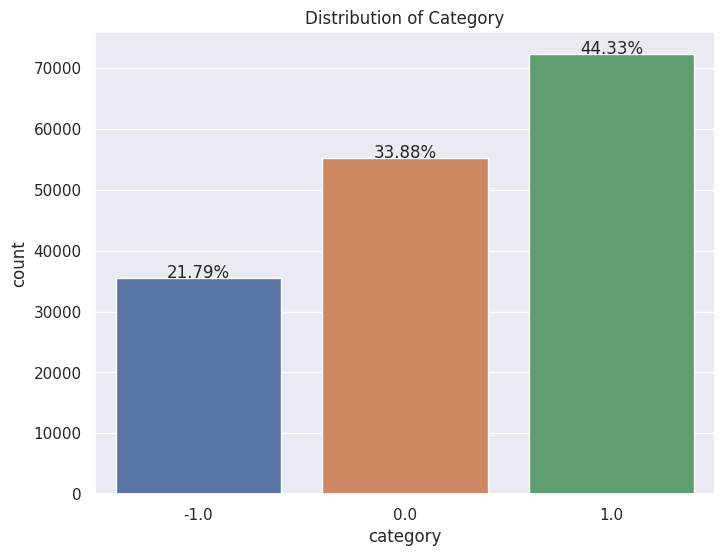

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))

# Create a countplot
ax = sns.countplot(x='category', data=df)

# Add percentages on top of each bar
total = float(len(df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1,
            f'{height / total * 100:.2f}%', ha="center")

plt.title("Distribution of Category")
plt.show()


 * **The data shows an imbalance, with more tweets labeled as positive(44.33%)
     compared to Neutral(33.88%) and negative(21.79%), which can impact model training and performance.**




# **Text Preprocessing**

---


In [ ]:
#finding the null values
df.isnull().sum()

clean_text    0
category      0
dtype: int64

In [ ]:
#drop the null values
df= df.dropna()
df.isnull().sum()

clean_text    0
category      0
dtype: int64

In [ ]:
#import nltk
#nltk.download('punkt')


In [ ]:
#import string
#string.punctuation



# **Removing Punctuation, Numbers, and Special Characters**

---


In [ ]:
df['clean_text']=df['clean_text'].str.replace("[^a-zA-Z#]", " ")
df.head()

<ipython-input-6-1036d5dc25b2>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_text']=df['clean_text'].str.replace("[^a-zA-Z#]", " ")
<ipython-input-6-1036d5dc25b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text']=df['clean_text'].str.replace("[^a-zA-Z#]", " ")


,clean_text,category
0,when modi promised minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


# **Tokenization**

---


*  **Tokenization**: Tokenization involves splitting text into individual words or tokens.



In [ ]:
import re
# Function to Tokenize words
def tokenize(text):
    tokens = re.split('\W+', text) #W+ means that either a word character (A-Za-z0-9_) or a dash (-) can go there.
    return tokens

df['clean_text_tokenized']= df['clean_text'].apply(lambda x:tokenize(x.lower()))
#We convert to lower as Python is case-sensitive.

df.head()

<ipython-input-7-30ace5da739e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text_tokenized']= df['clean_text'].apply(lambda x:tokenize(x.lower()))


,clean_text,category,clean_text_tokenized
0,when modi promised minimum government maximum...,-1.0,"[when, modi, promised, minimum, government, ma..."
1,talk all the nonsense and continue all the dra...,0.0,"[talk, all, the, nonsense, and, continue, all,..."
2,what did just say vote for modi welcome bjp t...,1.0,"[what, did, just, say, vote, for, modi, welcom..."
3,asking his supporters prefix chowkidar their n...,1.0,"[asking, his, supporters, prefix, chowkidar, t..."
4,answer who among these the most powerful world...,1.0,"[answer, who, among, these, the, most, powerfu..."


#  **Remove Stopwords**

---





* **Stopwords :-** Stopwords are common words (e.g., "the," "and," "in") that are often removed from text during preprocessing because they don't carry significant meaning for analysis.



In [ ]:
import nltk
nltk.download('stopwords')
stopword=nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Function to remove Stopwords
def remove_stopwords(tokenized_list):
    text = [word for word in tokenized_list if word not in stopword]# To remove all stopwords
    return text

df['clean_text_nostopword'] = df['clean_text_tokenized'].apply(lambda x: remove_stopwords(x))

df.head()

<ipython-input-9-3583f029817a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text_nostopword'] = df['clean_text_tokenized'].apply(lambda x: remove_stopwords(x))


,clean_text,category,clean_text_tokenized,clean_text_nostopword
0,when modi promised minimum government maximum...,-1.0,"[when, modi, promised, minimum, government, ma...","[modi, promised, minimum, government, maximum,..."
1,talk all the nonsense and continue all the dra...,0.0,"[talk, all, the, nonsense, and, continue, all,...","[talk, nonsense, continue, drama, vote, modi, ]"
2,what did just say vote for modi welcome bjp t...,1.0,"[what, did, just, say, vote, for, modi, welcom...","[say, vote, modi, welcome, bjp, told, rahul, m..."
3,asking his supporters prefix chowkidar their n...,1.0,"[asking, his, supporters, prefix, chowkidar, t...","[asking, supporters, prefix, chowkidar, names,..."
4,answer who among these the most powerful world...,1.0,"[answer, who, among, these, the, most, powerfu...","[answer, among, powerful, world, leader, today..."


## **Lemmatization**



* **Lemmatization: -** Lemmatization reduces words to their base or dictionary form.It standardizes words and reduces dimensionality.







In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
wnl = WordNetLemmatizer()

df['clean_text_lemmatized'] = df['clean_text_nostopword'].apply(lambda x:' '.join([wnl.lemmatize(i) for i in x]))
df.head()

<ipython-input-11-900b3980fa25>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text_lemmatized'] = df['clean_text_nostopword'].apply(lambda x:' '.join([wnl.lemmatize(i) for i in x]))


,clean_text,category,clean_text_tokenized,clean_text_nostopword,clean_text_lemmatized
0,when modi promised minimum government maximum...,-1.0,"[when, modi, promised, minimum, government, ma...","[modi, promised, minimum, government, maximum,...",modi promised minimum government maximum gover...
1,talk all the nonsense and continue all the dra...,0.0,"[talk, all, the, nonsense, and, continue, all,...","[talk, nonsense, continue, drama, vote, modi, ]",talk nonsense continue drama vote modi
2,what did just say vote for modi welcome bjp t...,1.0,"[what, did, just, say, vote, for, modi, welcom...","[say, vote, modi, welcome, bjp, told, rahul, m...",say vote modi welcome bjp told rahul main camp...
3,asking his supporters prefix chowkidar their n...,1.0,"[asking, his, supporters, prefix, chowkidar, t...","[asking, supporters, prefix, chowkidar, names,...",asking supporter prefix chowkidar name modi gr...
4,answer who among these the most powerful world...,1.0,"[answer, who, among, these, the, most, powerfu...","[answer, among, powerful, world, leader, today...",answer among powerful world leader today trump...


#  **Stemming**



*  **Stemming:-**  Stemming is the process of reducing words to their root form by removing prefixes or suffixes.



In [ ]:
from nltk import PorterStemmer

ps = PorterStemmer()

df['clean_text_stem'] = df['clean_text_nostopword'].apply(lambda x: ' '.join([ps.stem(i) for i in x]))
df.head()

<ipython-input-12-1294c47213cb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text_stem'] = df['clean_text_nostopword'].apply(lambda x: ' '.join([ps.stem(i) for i in x]))


,clean_text,category,clean_text_tokenized,clean_text_nostopword,clean_text_lemmatized,clean_text_stem
0,when modi promised minimum government maximum...,-1.0,"[when, modi, promised, minimum, government, ma...","[modi, promised, minimum, government, maximum,...",modi promised minimum government maximum gover...,modi promis minimum govern maximum govern expe...
1,talk all the nonsense and continue all the dra...,0.0,"[talk, all, the, nonsense, and, continue, all,...","[talk, nonsense, continue, drama, vote, modi, ]",talk nonsense continue drama vote modi,talk nonsens continu drama vote modi
2,what did just say vote for modi welcome bjp t...,1.0,"[what, did, just, say, vote, for, modi, welcom...","[say, vote, modi, welcome, bjp, told, rahul, m...",say vote modi welcome bjp told rahul main camp...,say vote modi welcom bjp told rahul main campa...
3,asking his supporters prefix chowkidar their n...,1.0,"[asking, his, supporters, prefix, chowkidar, t...","[asking, supporters, prefix, chowkidar, names,...",asking supporter prefix chowkidar name modi gr...,ask support prefix chowkidar name modi great s...
4,answer who among these the most powerful world...,1.0,"[answer, who, among, these, the, most, powerfu...","[answer, among, powerful, world, leader, today...",answer among powerful world leader today trump...,answer among power world leader today trump pu...


In [ ]:
positive_words = [word for word, cat in zip(df['clean_text_nostopword'], df['category']) if cat == 1.0]
negative_words = [word for word, cat in zip(df['clean_text_nostopword'], df['category']) if cat == -1.0]
neutral_words = [word for word, cat in zip(df['clean_text_nostopword'], df['category']) if cat == 0.0]


print('positive_words:',len(positive_words))
print('negative_words:',len(negative_words))
print('neutral_words:',len(neutral_words))

positive_words: 72249
negative_words: 35509
neutral_words: 55211




* The total number of Positive sentiment words were 72249, Negative sentiment words were 35509 & Neutral sentiment words were 55211.








#   **Data Visualisation**

---



*  Using Wordcloud Technique to Visualize positive and negative text




In [ ]:
Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))
image_colors = ImageColorGenerator(Mask)

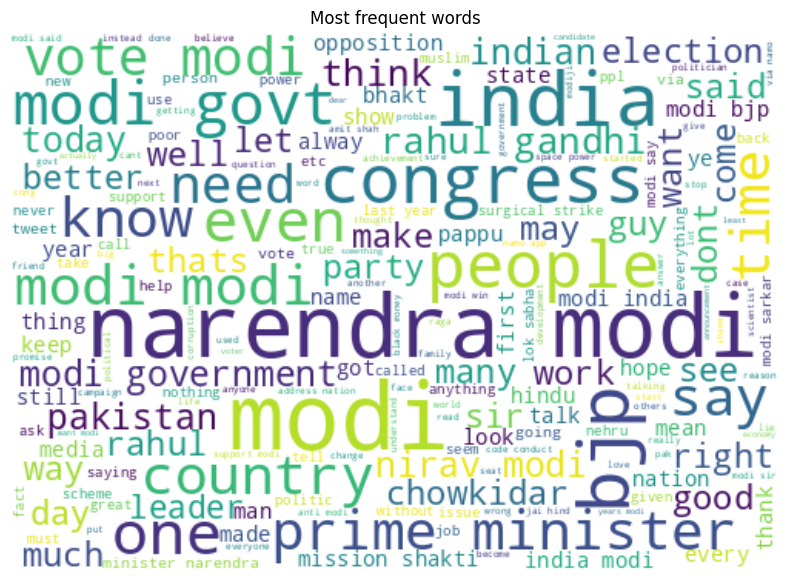

In [ ]:
# Flatten the list of lists into a single list of words
all_words = [word for word_list in df['clean_text_nostopword'] for word in word_list]

# Join the words into a single string
frequent_words = ' '.join(all_words)

# Create the word cloud
wordcloud = WordCloud(width=500, height=350, max_font_size=60,
                      background_color='white', colormap='viridis').generate(frequent_words)

# Display the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Most frequent words")
plt.axis('off')
plt.show()


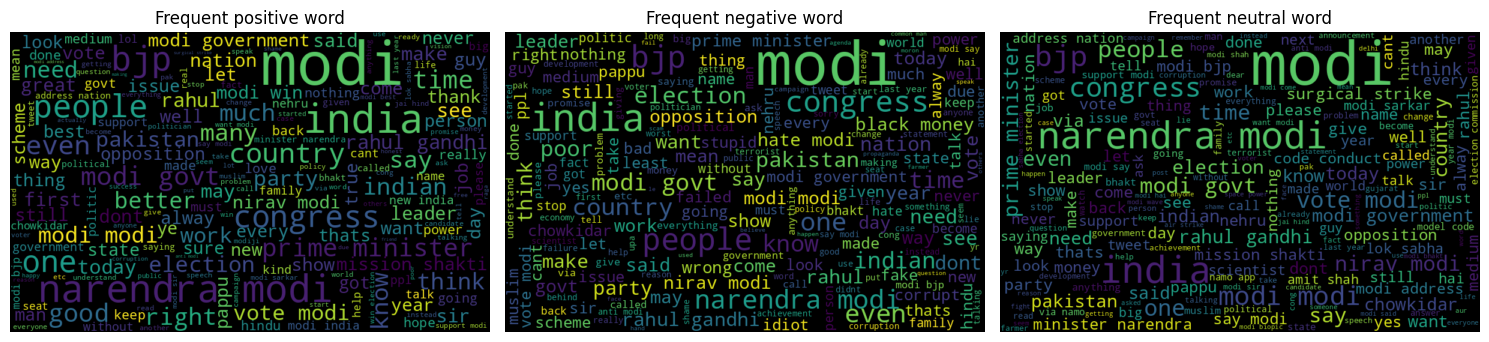

In [ ]:
# frequent words visualization
freq_positive_word= " ".join([word for word in df['clean_text_lemmatized'][df['category']==1]])
freq_negative_word= " ".join([word for word in df['clean_text_lemmatized'][df['category']==-1]])
freq_neutral_word= " ".join([word for word in df['clean_text_lemmatized'][df['category']==0]])


positive_wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(freq_positive_word)
negative_wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(freq_negative_word)
neutral_wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(freq_neutral_word)


plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Frequent positive word')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Frequent negative word')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.title('Frequent neutral word')
plt.axis('off')

plt.tight_layout()
plt.show()

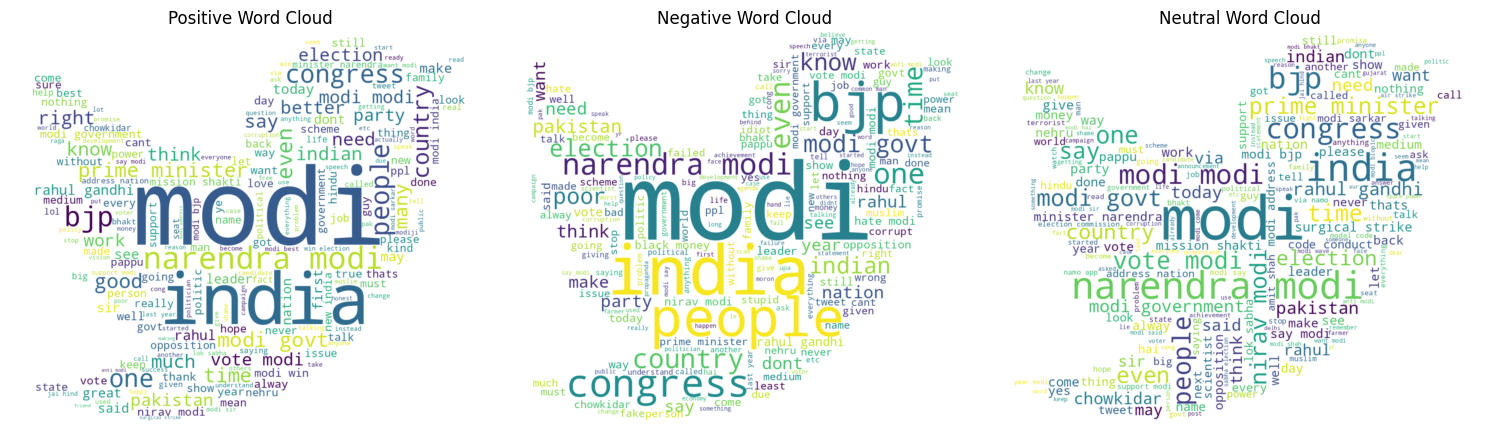

In [ ]:
# Extract positive and negative text as single strings
positive_text = ' '.join(df[df['category'] == 1]['clean_text_lemmatized'])
negative_text = ' '.join(df[df['category'] == -1]['clean_text_lemmatized'])
neutral_text = ' '.join(df[df['category'] == 0]['clean_text_lemmatized'])


# Create WordClouds for positive and negative text
positive_wordcloud = WordCloud(width=800, height=400, background_color='white', mask=Mask).generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white', mask=Mask).generate(negative_text)
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white', mask=Mask).generate(neutral_text)


plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Word Cloud')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Word Cloud')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.title('Neutral Word Cloud')
plt.axis('off')

plt.tight_layout()
plt.show()




# **Feature Extraction**

---

### **Convert the text data into numerical features using techniques TF-IDF(Term Frequency-Inverse Document Frequency)**


##  **TF (Term Frequency):**




* **Term Frequency measures how often a word appears in a document.**

* **Words that appear more times in a document get higher TF scores**.

*  **It helps identify important words within a document**.




##  **IDF (Inverse Document Frequency):**


  
*   **Inverse Document Frequency measures the importance of a word across all
documents in a collection (corpus)**

*  **Words that are rare across all documents get higher IDF scores.**


* **It helps identify words that are distinctive and not common in all documents.**



##  **TF-IDF (Term Frequency-Inverse Document Frequency):**


* **TF-IDF combines TF and IDF to determine the importance of a word in a specific document compared to its importance across all documents in the corpus ,It assigns higher values to words that are important within a specific document but not common across all documents**

* **TF-IDF helps in text analysis, information retrieval, and text classification by identifying the significance of words in a document,In simpler terms, TF-IDF is a way to give more weight to words that are important in a single document but not very common in all documents. It helps in extracting meaningful information from text data for various natural language processing tasks**


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
tf_wb= TfidfVectorizer(max_features=1000)
X_tf = tf_wb.fit_transform(df['clean_text_lemmatized'])
X_tf = X_tf.toarray()

In [ ]:
X_tf.shape

(162969, 1000)

In [ ]:
# Splitting the dataset into the Training and Testing set.
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, df['category'].values, test_size=0.2,random_state = 27)


In [ ]:
X_train_tf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
X_test_tf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
print("Size of X_train_tf: ", (X_train_tf.shape))
print("Size of X_test_tf: ", (X_test_tf.shape))
print("Size of y_train_tf: ", (y_train_tf.shape))
print("Size of y_test_tf: ", (y_test_tf.shape))

Size of X_train_tf:  (130375, 1000)
Size of X_test_tf:  (32594, 1000)
Size of y_train_tf:  (130375,)
Size of y_test_tf:  (32594,)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_tf = scaler.fit_transform(X_train_tf)

X_test_tf = scaler.transform(X_test_tf)

In [ ]:
#X_train_tf

array([[-0.06605946, -0.04365585, -0.07031491, ..., -0.04742159,
        -0.07351682, -0.0907395 ],
       [-0.06605946, -0.04365585, -0.07031491, ..., -0.04742159,
        -0.07351682, -0.0907395 ],
       [-0.06605946, -0.04365585, -0.07031491, ..., -0.04742159,
        -0.07351682, -0.0907395 ],
       ...,
       [-0.06605946, -0.04365585, -0.07031491, ..., -0.04742159,
        -0.07351682, -0.0907395 ],
       [-0.06605946, -0.04365585, -0.07031491, ..., -0.04742159,
        -0.07351682, -0.0907395 ],
       [-0.06605946, -0.04365585, -0.07031491, ..., -0.04742159,
        -0.07351682, -0.0907395 ]])

In [ ]:
from collections import Counter
Counter(y_train_tf)

Counter({-1.0: 28423, 1.0: 57598, 0.0: 44354})

## **SMOTE (Synthetic Minority Over-sampling Technique)for Imbalanced Classification**

---



* **SMOTE(Synthetic Minority Over-sampling Technique)**  addresses imbalanced datasets by creating synthetic instances for the minority class, improving model training on under-represented classes. It works by generating artificial data points between existing minority class instances.



In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tf, y_train_tf)

In [ ]:
X_train_resampled.shape

(172794, 1000)

In [ ]:
y_train_resampled.shape

(172794,)

In [ ]:
print("Size of X_train_resampled: ", (X_train_resampled.shape))
print("Size of y_train_resampled: ", (y_train_resampled.shape))
print("Size of X_test_tf: ", (X_test_tf.shape))
print("Size of y_test_tf: ", (y_test_tf.shape))

Size of X_train_resampled:  (172794, 1000)
Size of y_train_resampled:  (172794,)
Size of X_test_tf:  (32594, 1000)
Size of y_test_tf:  (32594,)


In [ ]:
#type(y_train_resampled)

In [ ]:
#X_train_resampled.shape[1]

#  **One-Hot Encoding for Multi-Class Classification**

---


In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_resampled_encoded = to_categorical(y_train_resampled, num_classes=3)
y_test_tf_encoded = to_categorical(y_test_tf, num_classes=3)

In [ ]:
print(y_train_resampled_encoded.shape)
print(y_test_tf_encoded.shape)

(172794, 3)
(32594, 3)


# **Model Building- Using Deep Neural Network**

---

### **model-1**    -**Simple Feedforward Neural Network**

In [ ]:
!pip install keras
!pip install tensorflow

*   **Model Type**: A Simple Feedforward Neural Network was constructed.

*  **Hidden Layers**: The network comprises two hidden layers, both utilizing the Rectified Linear Unit (ReLU) activation function.

*   **Output Layer**: The output layer has 3 nodes for classifying into three categories.












In [ ]:
model = Sequential()
model.add(Dense(128, input_dim=X_train_resampled.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))  #3 output classes

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               128128    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 136579 (533.51 KB)
Trainable params: 136579 (533.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


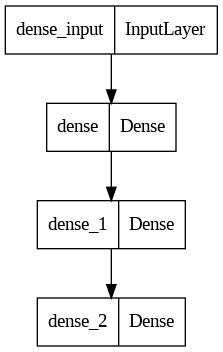

In [ ]:
plot_model(model)

In [ ]:
model_history=model.fit(X_train_resampled, y_train_resampled_encoded, epochs=10, batch_size=32, validation_split=0.2)
model_history

Epoch 1/10
4320/4320 [==============================] - 24s 4ms/step - loss: 0.6385 - accuracy: 0.7483 - val_loss: 0.5236 - val_accuracy: 0.7985
Epoch 2/10
4320/4320 [==============================] - 29s 7ms/step - loss: 0.5360 - accuracy: 0.7954 - val_loss: 0.5300 - val_accuracy: 0.7947
Epoch 3/10
4320/4320 [==============================] - 20s 5ms/step - loss: 0.4825 - accuracy: 0.8168 - val_loss: 0.3867 - val_accuracy: 0.8658
Epoch 4/10
4320/4320 [==============================] - 17s 4ms/step - loss: 0.4235 - accuracy: 0.8405 - val_loss: 0.3217 - val_accuracy: 0.8946
Epoch 5/10
4320/4320 [==============================] - 17s 4ms/step - loss: 0.3689 - accuracy: 0.8616 - val_loss: 0.2924 - val_accuracy: 0.9084
Epoch 6/10
4320/4320 [==============================] - 17s 4ms/step - loss: 0.3208 - accuracy: 0.8805 - val_loss: 0.2664 - val_accuracy: 0.9078
Epoch 7/10
4320/4320 [==============================] - 17s 4ms/step - loss: 0.2822 - accuracy: 0.8958 - val_loss: 0.2339 - val_ac

In [ ]:
model.evaluate(X_test_tf, y_test_tf_encoded)

1019/1019 [==============================] - 4s 4ms/step - loss: 1.1039 - accuracy: 0.7566


[1.1039137840270996, 0.7566423416137695]



* **The model performs well on the training data 93.83% accuracy but slightly less on the testing data 75.66%.This indicates overfitting**



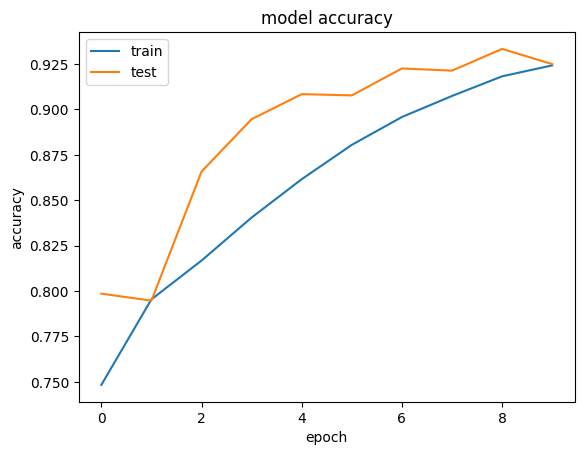

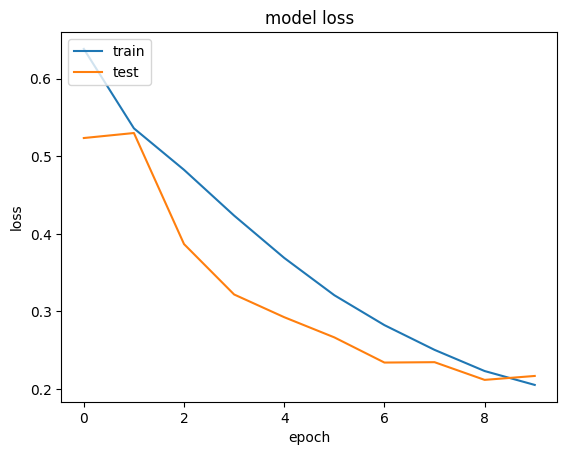

In [ ]:
# Model Performance Charts

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test_tf)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_tf_encoded, axis=1)

#  classification report
print(classification_report(y_true, y_pred_classes))

# confusion matrix
print(confusion_matrix(y_true, y_pred_classes))


1019/1019 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.73      0.84      0.78     10857
           1       0.82      0.78      0.80     14651
           2       0.68      0.58      0.63      7086

    accuracy                           0.76     32594
   macro avg       0.74      0.73      0.73     32594
weighted avg       0.76      0.76      0.75     32594

[[ 9082  1054   721]
 [ 1966 11478  1207]
 [ 1447  1537  4102]]


## **model-2  -Convolutional Neural Network (CNN)**


---

In [ ]:

Cnn_model = Sequential()
Cnn_model.add(Conv1D(32, 5, activation='relu', input_shape=(X_train_resampled.shape[1], 1)))
Cnn_model.add(MaxPooling1D(pool_size=2))
Cnn_model.add(Conv1D(64, 5, activation='relu', input_shape=(X_train_resampled.shape[1], 1)))
Cnn_model.add(MaxPooling1D(pool_size=2))
Cnn_model.add(Flatten())
Cnn_model.add(Dense(128, activation='relu'))
Cnn_model.add(Dense(3, activation='softmax'))


In [ ]:
Cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
print(Cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 996, 32)           192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 498, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 494, 64)           10304     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 247, 64)           0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 15808)             0         
                                                                 
 dense_3 (Dense)             (None, 128)              

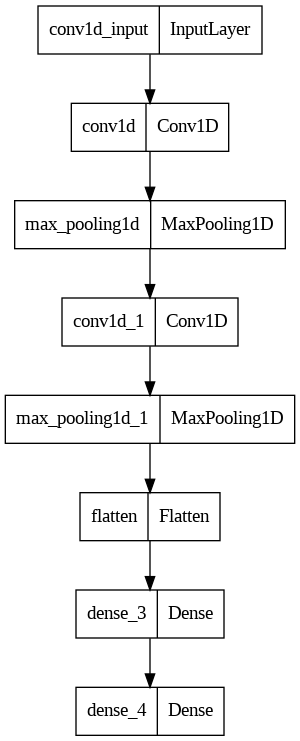

In [ ]:
plot_model(Cnn_model)

In [ ]:
cnn_model_history=Cnn_model.fit(X_train_resampled, y_train_resampled_encoded, epochs=10, batch_size=32, validation_split=0.2)
cnn_model_history

Epoch 1/10
4320/4320 [==============================] - 33s 6ms/step - loss: 0.6732 - accuracy: 0.7302 - val_loss: 0.5431 - val_accuracy: 0.7946
Epoch 2/10
4320/4320 [==============================] - 24s 6ms/step - loss: 0.5498 - accuracy: 0.7917 - val_loss: 0.4671 - val_accuracy: 0.8311
Epoch 3/10
4320/4320 [==============================] - 23s 5ms/step - loss: 0.4687 - accuracy: 0.8237 - val_loss: 0.4441 - val_accuracy: 0.8483
Epoch 4/10
4320/4320 [==============================] - 25s 6ms/step - loss: 0.3894 - accuracy: 0.8548 - val_loss: 0.4325 - val_accuracy: 0.8595
Epoch 5/10
4320/4320 [==============================] - 25s 6ms/step - loss: 0.3180 - accuracy: 0.8830 - val_loss: 0.3638 - val_accuracy: 0.8872
Epoch 6/10
4320/4320 [==============================] - 26s 6ms/step - loss: 0.2574 - accuracy: 0.9066 - val_loss: 0.4095 - val_accuracy: 0.8824
Epoch 7/10
4320/4320 [==============================] - 25s 6ms/step - loss: 0.2097 - accuracy: 0.9255 - val_loss: 0.4199 - val_ac

In [ ]:
Cnn_model.evaluate(X_test_tf, y_test_tf_encoded)

1019/1019 [==============================] - 3s 3ms/step - loss: 1.5860 - accuracy: 0.7342


[1.5859639644622803, 0.7342455387115479]



* **The second model, a CNN, achieved a higher training accuracy (95.52%) but a similar testing accuracy (73.84%) compared to the previous model.While training performance improved, the gap between training and testing accuracies suggests a potential overfitting issue in the model**





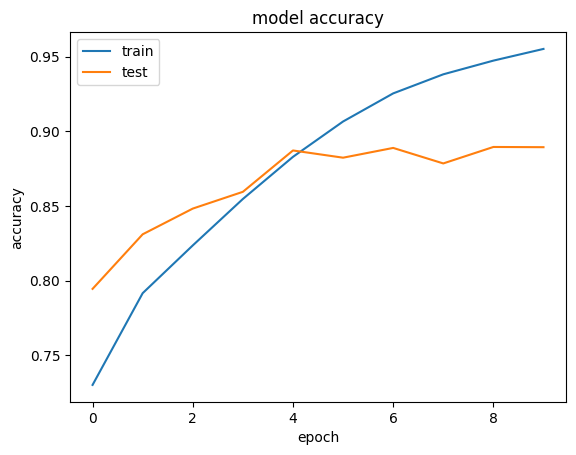

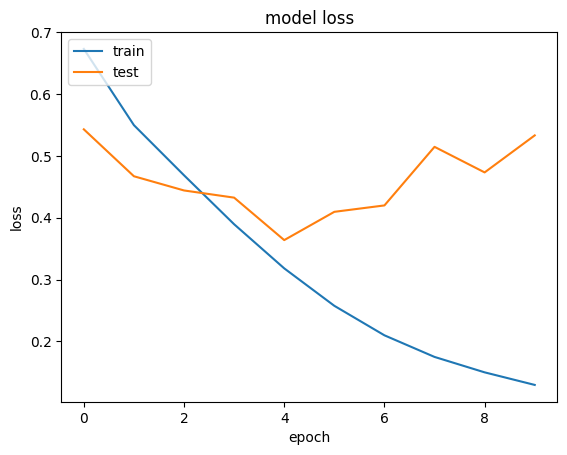

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['accuracy'])
plt.plot(cnn_model_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')


plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
cnn_y_pred = Cnn_model.predict(X_test_tf)
y_pred_classes = np.argmax(cnn_y_pred, axis=1)
y_true = np.argmax(y_test_tf_encoded, axis=1)

#  classification report
print(classification_report(y_true, y_pred_classes))

# confusion matrix
print(confusion_matrix(y_true, y_pred_classes))

1019/1019 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.73      0.79      0.76     10857
           1       0.79      0.77      0.78     14651
           2       0.62      0.59      0.60      7086

    accuracy                           0.73     32594
   macro avg       0.71      0.71      0.71     32594
weighted avg       0.73      0.73      0.73     32594

[[ 8526  1352   979]
 [ 1836 11253  1562]
 [ 1306  1627  4153]]


# **model-3 -Convolutional Neural Network (CNN)**

## **Overfitting Prevention in CNN Model:**

### **Batch Normalization:**



*   **Applied batch normalization after each convolutional layer.**
*  **Normalizes the activations, helping in stabilizing and accelerating the training process.**



### **Dropout:**

*   **Implemented dropout layers after each max-pooling layer and dense layer.**
*   **Randomly drops a specified fraction of connections, preventing over-reliance on specific features.**


### **Early Stopping:**


*   **Utilized early stopping with a patience of 3 epochs.**
*   **Monitored the validation loss and restored the best weights when the loss did not improve for consecutive epochs.**


### **MaxPooling:**

* **Applied max-pooling layers to down-sample feature maps, reducing the likelihood of overfitting.**

### **Lower Learning Rate:**


*   **Compiled the model with a lower learning rate (0.001) using the Adam optimizer.**


In [ ]:

CNN_model = Sequential()
CNN_model.add(Conv1D(64, 5, activation='relu', input_shape=(X_train_resampled.shape[1], 1)))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling1D(pool_size=2))
CNN_model.add(Dropout(0.5))

CNN_model.add(Conv1D(128, 5, activation='relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling1D(pool_size=2))
CNN_model.add(Dropout(0.5))

CNN_model.add(Conv1D(256, 5, activation='relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling1D(pool_size=2))
CNN_model.add(Dropout(0.5))

CNN_model.add(Flatten())
CNN_model.add(Dense(256, activation='relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(Dropout(0.5))
CNN_model.add(Dense(3, activation='softmax'))

# Compile the model with learning rate
optimizer = Adam(learning_rate=0.001)
CNN_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

CNN_model_history = CNN_model.fit(
    X_train_resampled, y_train_resampled_encoded,
    epochs=18,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/18
2160/2160 [==============================] - 79s 29ms/step - loss: 0.8742 - accuracy: 0.6265 - val_loss: 1.0222 - val_accuracy: 0.6028
Epoch 2/18
2160/2160 [==============================] - 62s 29ms/step - loss: 0.6894 - accuracy: 0.7192 - val_loss: 0.5657 - val_accuracy: 0.7907
Epoch 3/18
2160/2160 [==============================] - 62s 29ms/step - loss: 0.6514 - accuracy: 0.7387 - val_loss: 0.7126 - val_accuracy: 0.7306
Epoch 4/18
2160/2160 [==============================] - 63s 29ms/step - loss: 0.6276 - accuracy: 0.7530 - val_loss: 0.5569 - val_accuracy: 0.8044
Epoch 5/18
2160/2160 [==============================] - 62s 29ms/step - loss: 0.6084 - accuracy: 0.7609 - val_loss: 0.5469 - val_accuracy: 0.8092
Epoch 6/18
2160/2160 [==============================] - 63s 29ms/step - loss: 0.5919 - accuracy: 0.7689 - val_loss: 0.5079 - val_accuracy: 0.8270
Epoch 7/18
2160/2160 [==============================] - 62s 29ms/step - loss: 0.5761 - accuracy: 0.7757 - val_loss: 0.5763 -

In [ ]:
CNN_model.evaluate(X_test_tf, y_test_tf_encoded)

1019/1019 [==============================] - 6s 6ms/step - loss: 0.5956 - accuracy: 0.7855


[0.5955911874771118, 0.7855433225631714]

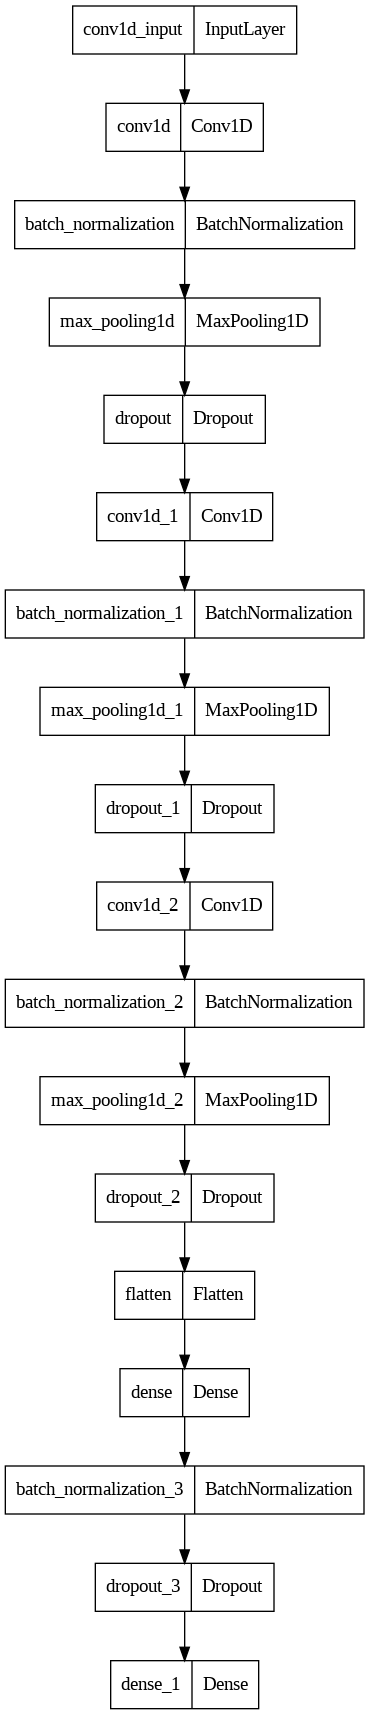

In [ ]:
plot_model(CNN_model)

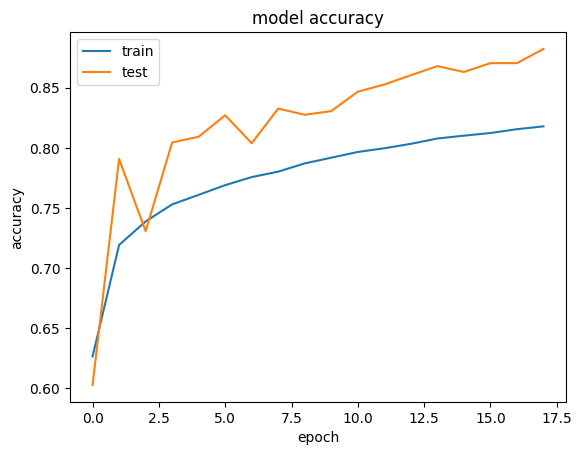

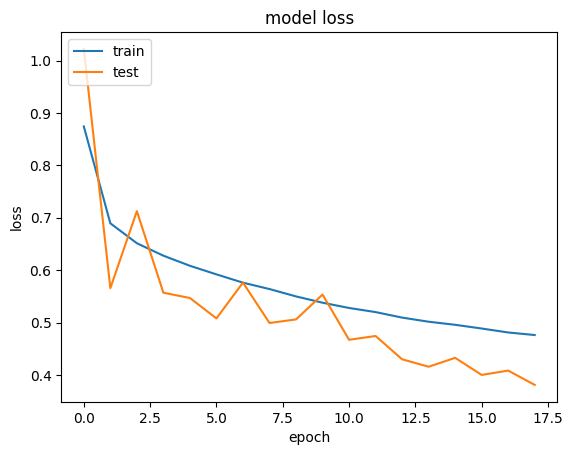

In [ ]:
# Model Performance Charts

plt.plot(CNN_model_history.history['accuracy'])
plt.plot(CNN_model_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')


plt.show()

plt.plot(CNN_model_history.history['loss'])
plt.plot(CNN_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
CNN_y_pred = CNN_model.predict(X_test_tf)
y_pred_classes = np.argmax(CNN_y_pred, axis=1)
y_true = np.argmax(y_test_tf_encoded, axis=1)

#  classification report
print(classification_report(y_true, y_pred_classes))

# confusion matrix
print(confusion_matrix(y_true, y_pred_classes))

1019/1019 [==============================] - 5s 5ms/step
              precision    recall  f1-score   support

           0       0.72      0.93      0.81     10857
           1       0.88      0.77      0.82     14651
           2       0.76      0.61      0.67      7086

    accuracy                           0.79     32594
   macro avg       0.78      0.77      0.77     32594
weighted avg       0.80      0.79      0.78     32594

[[10072   436   349]
 [ 2386 11230  1035]
 [ 1618  1166  4302]]


*   **The third model used techniques like batch normalization, dropout, and early stopping to improve its performance. It achieved a training accuracy of 81.78% and a testing accuracy of 78.58%. These methods helped prevent overfitting, making the model better at handling new, unseen data.**

#  **Save the Model**

In [ ]:
import pickle

# save the CNN Model-3 as a pickle file
model_pkl_file = "Model-3.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(CNN_model, file)
